## Figure 3c

Precision @ 10 plots

In [1]:
import glob
import numpy as np
import torch
import scanpy as sc
import pandas as pd 
import copy
import sys
import os
sys.path.append('../')

from data import PertDataloader
from inference import evaluate, compute_metrics
from inference import GIs
import matplotlib.patches as mpatches

# Linear model fitting functions
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from dcor import distance_correlation, partial_distance_correlation
from sklearn.metrics import r2_score
from fig_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

device = 'cuda:3'
home_dir = '/dfs/user/yhr/perturb_GNN/pertnet/'
sys.path.append(home_dir)

GI_names = [k.lower() for k in GIs.keys()]

In [2]:
font = {'family' : 'normal',
        'size'   : 18}

import matplotlib
matplotlib.rc('font', **font)

In [3]:
# Filenames
crossgene_names = glob.glob('/dfs/user/yhr/snap/perturb_GNN/pertnet-cli/GI_subtypes_out_v2/*crossgene*.npy')
cpa_names = glob.glob('/dfs/user/yhr/CPA_orig/compert/GI_subtypes_out/*.npy')
naive_names = glob.glob('/dfs/user/yhr/perturb_GNN/pertnet/GI_subtypes_out_v2/naive_seen2.npy')

In [4]:
k = 10
num_samples=1000
dict_ = {}
dict_['cpa'] = {}
dict_['pertnet'] = {}
dict_['naive'] = {}
dfs = {}

for metric in [('eq_contr', 'epistasis'), ('corr_fit', 'neomorphic'), 
               ('dcor', 'redundant'),('mag','suppressor'),
               ('mag','synergy')]:     


    p,t,p_names,t_names = get_t_p_seen1(metric[0], crossgene_names, return_names=True, uncert_filter=True)
    dict_['pertnet'][metric[1]], _ = get_prec_atk(p, t, p_names, t_names, GI_type=metric[1], k=k)

    dict_['naive'][metric[1]] = []
    for it in range(num_samples):
        score, _ = get_prec_atk(p, t, p_names, t_names, GI_type=metric[1], k=k, random=True)
        dict_['naive'][metric[1]].append(score)
    
precision_at_10 = dict_

### Defining thresholds with Other category

In [51]:
np.sort(get_t_p_seen2('mag', crossgene_names, return_names=True)[1]['synergy'])

array([1.14685077, 1.22283352, 1.22374483, 1.29699299, 1.36901979,
       1.39121458, 1.40643537, 1.41980339, 1.42233745, 1.42566483,
       1.44837729, 1.4794279 , 1.4813906 , 1.48142552, 1.48238693,
       1.48591728, 1.4908992 , 1.5040171 , 1.51098667, 1.54303704,
       1.57853654, 1.66771325, 1.67309386, 1.74901558, 1.78204039,
       1.86192267, 1.86304945, 1.89033026, 2.09163154, 2.16035494])

In [61]:
vs = np.hstack([v for v in get_t_p_seen2('mag', crossgene_names, return_names=True)[1].values()])
np.sum(vs>1.15)/len(vs)

0.4906832298136646

In [10]:
vs = np.hstack([v for v in get_t_p_seen2('mag', crossgene_names, return_names=True)[1].values()])
np.sum(vs<1.0)/len(vs)

0.37888198757763975

In [11]:
vs = np.hstack([v for v in get_t_p_seen2('dcor', crossgene_names, return_names=True)[1].values()])
np.sum(vs>0.85)/len(vs)

0.16149068322981366

In [58]:
vs = np.hstack([v for v in get_t_p_seen2('corr_fit', crossgene_names, return_names=True)[1].values()])
np.sum(vs<0.88)/len(vs)

0.4906832298136646

In [13]:
vs = np.hstack([v for v in get_t_p_seen2('dominance', crossgene_names, return_names=True)[1].values()])
np.sum(vs>0.35)/len(vs)

0.2111801242236025

In [26]:
vs = np.hstack([v for v in get_t_p_seen2('eq_contr', crossgene_names, return_names=True)[1].values()])
np.sum(vs<0.30)/len(vs)

0.11180124223602485

### Defining thresholds without Other category

In [33]:
vs = np.hstack([v for v in get_t_p_seen2('mag', crossgene_names, return_names=True)[1].values()])
np.sum(vs>1.15)/len(vs)

0.4906832298136646

In [58]:
vs = np.hstack([v for v in get_t_p_seen2('mag', crossgene_names, return_names=True)[1].values()])
np.sum(vs<1.0)/len(vs)

0.3135593220338983

In [59]:
vs = np.hstack([v for v in get_t_p_seen2('dcor', crossgene_names, return_names=True)[1].values()])
np.sum(vs>0.85)/len(vs)

0.15254237288135594

In [82]:
vs = np.hstack([v for v in get_t_p_seen2('corr_fit', crossgene_names, return_names=True)[1].values()])
np.sum(vs<0.85)/len(vs)

0.3305084745762712

In [75]:
vs = np.hstack([v for v in get_t_p_seen2('dominance', crossgene_names, return_names=True)[1].values()])
np.sum(vs>0.35)/len(vs)

0.2033898305084746

In [67]:
vs = np.hstack([v for v in get_t_p_seen2('eq_contr', crossgene_names, return_names=True)[1].values()])
np.sum(vs<0.3)/len(vs)

0.11864406779661017

### Make box plot with control 

In [17]:
ticklabel_map = {'synergy': 'Synergy',
                 'suppressor':'Suppression',
                 'neomorphic':'Neomorphism',
                 'redundant':'Redundancy',
                 'epistasis':'Epistasis',
                 'epistatic':'Epistasis',
                 'additive':'Additivity'}

In [6]:
import numpy as np
import scipy.stats


def CI(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

(0.0, 1.1)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


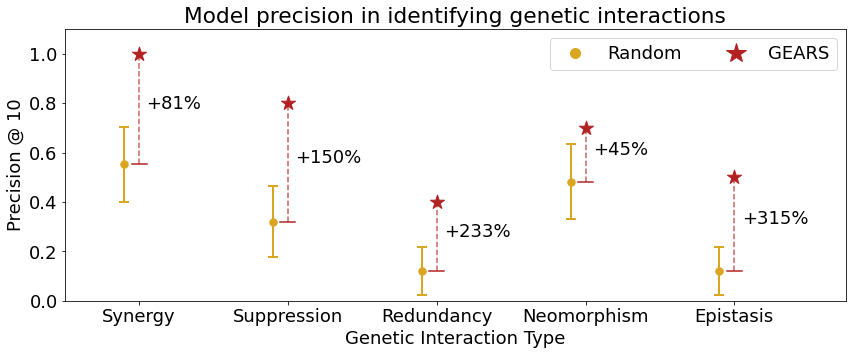

In [7]:
## Compare to random

import matplotlib
font = {'family' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

legend=True
keys = list(precision_at_10['naive'].keys())
keys = np.sort(list(keys))[::-1]
naive_values = [precision_at_10['naive'][k] for k in keys]

medianprops = dict(color='black')
fig = plt.figure(figsize=[14,5])

keys_ = [ticklabel_map[x] for x in keys]

for it, k in enumerate(keys):
    plt.scatter(it+1-0.1, np.mean(naive_values[it]), marker='.', 
                s=220, color='goldenrod')
    box = plt.errorbar(it+1-0.1, np.mean(naive_values[it]), capsize=5, 
                       elinewidth=2,markeredgewidth=2,
                       yerr=np.std(naive_values[it]), color='goldenrod')
    plt.scatter(it+1, precision_at_10['pertnet'][k], marker='*', 
                s=220, color='firebrick')
    
    # Annotation
    line_bot = np.mean(naive_values[it])
    line_top = precision_at_10['pertnet'][k]
    text_pos = (line_bot + line_top)/2
    improve = (line_top-line_bot)/line_bot * 100
    plt.plot([it+1,it+1],[line_bot,line_top], color='firebrick', 
                          linestyle='--', alpha=0.7)
    plt.annotate('+{0:.0f}%'.format(improve),(it+1.05, text_pos))
    plt.plot([it+0.95,it+1.05],[line_bot,line_bot], color='firebrick')
    #plt.scatter(it+1, precision_at_10['cpa'][k], marker='*', 
    #            s=130, color='blue')
    
plt.ylim([-0.1,1])
plt.ylabel('Precision @ 10')

yellow_dot = plt.Line2D((0,1),(0,0), color='goldenrod', marker='.', 
                       markersize=20, linestyle='', label='Random')
red_star = plt.Line2D((0,1),(0,0), color='firebrick', marker='*', 
                       markersize=20, linestyle='', label='GEARS')
#blue_star = plt.Line2D((0,1),(0,0), color='blue', marker='*',markersize=20,
#                       linestyle='', label='CPA')

if legend:
    plt.legend(handles=[yellow_dot, red_star], 
               bbox_to_anchor=(1.0, 1.0), ncol=2)

plt.title('Model precision in identifying genetic interactions')
_ = plt.xticks(np.arange(1,it+2), keys_)

plt.xlim([0.5,it+1.75])
plt.xlabel('Genetic Interaction Type')
plt.ylim([0,1.1])

## Top 10 accuracy

In [8]:
k = 10
num_samples=1000
dict_ = {}
dict_['cpa'] = {}
dict_['pertnet'] = {}
dict_['naive'] = {}
dfs = {}

for metric in [('eq_contr', 'epistasis', 'min'), ('corr_fit', 'neomorphic', 'min'), 
               ('dcor', 'redundant', 'max'),('mag','suppressor', 'min'),
               ('mag','synergy', 'max')]:       

    p,t,p_names,t_names = get_t_p_seen1(metric[0], crossgene_names, return_names=True, uncert_filter=True)
    dict_['pertnet'][metric[1]] = get_topk_acc(p, t, p_names, t_names,  min_max=metric[2], k=k)

    dict_['naive'][metric[1]] = []
    for it in range(num_samples):
        score = get_topk_acc(p, t, p_names, t_names,  min_max=metric[2], k=k, random=True)
        dict_['naive'][metric[1]].append(score)
    
top_10_acc = dict_

(0.0, 1.0)

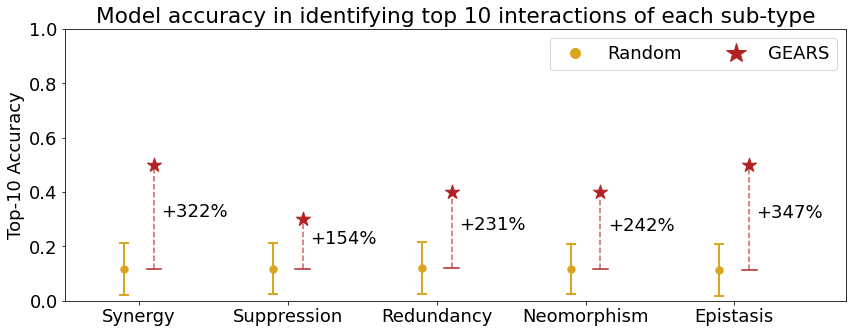

In [9]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

legend=True
keys = list(top_10_acc['naive'].keys())
keys = np.sort(list(keys))[::-1]
naive_values = [top_10_acc['naive'][k] for k in keys]

medianprops = dict(color='black')
fig = plt.figure(figsize=[14,5])

keys_ = [ticklabel_map[x] for x in keys]

for it, k in enumerate(keys):
    plt.scatter(it+1-0.1, np.mean(naive_values[it]), marker='.', 
                s=220, color='goldenrod')
    box = plt.errorbar(it+1-0.1, np.mean(naive_values[it]), capsize=5, 
                       elinewidth=2,markeredgewidth=2,
                       yerr=np.std(naive_values[it]), color='goldenrod')
    plt.scatter(it+1+0.1, top_10_acc['pertnet'][k], marker='*', 
                s=220, color='firebrick')
    
    # Annotation
    line_bot = np.mean(top_10_acc['naive'][k])
    line_top = top_10_acc['pertnet'][k]
    text_pos = (line_bot + line_top)/2
    improve = (line_top-line_bot)/line_bot * 100
    plt.plot([it+1+0.1,it+1+0.1],[line_bot,line_top], color='firebrick', 
                          linestyle='--', alpha=0.7)
    plt.annotate('+{0:.0f}%'.format(improve),(it+1.15, text_pos))
    plt.plot([it+1.05,it+1.15],[line_bot,line_bot], color='firebrick')
    
plt.ylim([-0.1,1])
plt.ylabel('Top-10 Accuracy')

yellow_dot = plt.Line2D((0,1),(0,0), color='goldenrod', marker='.', 
                       markersize=20, linestyle='', label='Random')
red_star = plt.Line2D((0,1),(0,0), color='firebrick', marker='*', 
                       markersize=20, linestyle='', label='GEARS')

if legend:
    plt.legend(handles=[yellow_dot, red_star], 
               bbox_to_anchor=(1.0, 1.0), ncol=2)

plt.title('Model accuracy in identifying top 10 interactions of each sub-type')
_ = plt.xticks(np.arange(1,it+2), keys_)
#plt.xlabel('Genetic Interaction Type')

_ = plt.xticks(np.arange(1,it+2), keys_)


plt.xlim([0.5,it+1.75])
plt.ylim([0,1.0])

In [10]:
cg_seen1_df = pd.DataFrame(get_all_pr_scores(crossgene_names, seen=1))
cg_seen1_df['model'] = 'PertNet'

#cg_seen1_df = cg_seen1_df.drop(columns=['additive'])

(0.0, 1.0)

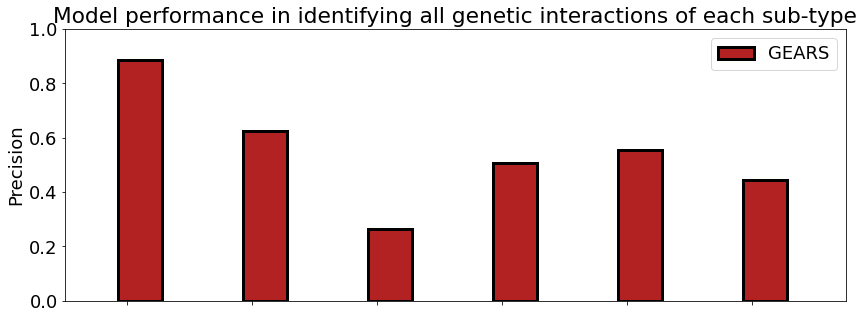

In [19]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

legend=True
fig = plt.figure(figsize=[14,5])

metric = 'precision'

keys_ = np.sort(cg_seen1_df.columns[:-1])[::-1]

for it, k in enumerate(keys_):
    plt.bar(it+1+0.1, cg_seen1_df.loc[metric, k], width=0.35, edgecolor='black',
                 linewidth='3', color='firebrick')
    
plt.ylim([-0.1,1])
plt.ylabel(metric.title())

red_star = plt.Line2D((0,1),(0,0), color='firebrick', marker='*', 
                       markersize=20, linestyle='', label='PertNet')

if legend:
    plt.legend(['GEARS'], bbox_to_anchor=(1.0, 1.0))

plt.title('Model performance in identifying all genetic interactions of each sub-type')
#plt.xlabel('Genetic Interaction Type')

_ = plt.xticks(np.arange(1,it+2), ['' for s in keys_])


plt.xlim([0.5,it+1.75])
plt.ylim([0,1.0])

(0.0, 1.1)

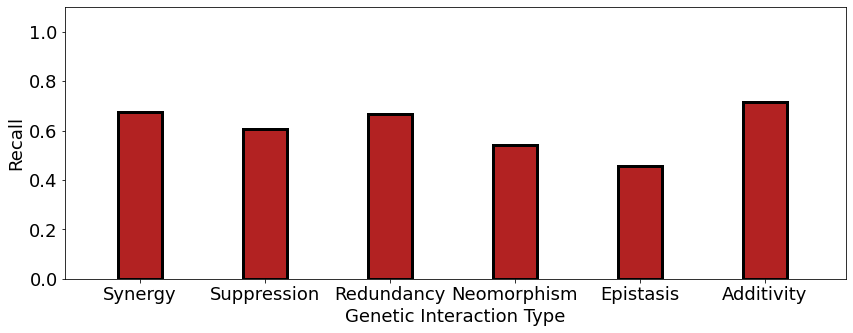

In [18]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

legend=True
fig = plt.figure(figsize=[14,5])

metric = 'recall'
keys_ = np.sort(cg_seen1_df.columns[:-1])[::-1]

for it, k in enumerate(keys_):
    plt.bar(it+1+0.1, cg_seen1_df.loc[metric, k], width=0.35, edgecolor='black',
                 linewidth='3', color='firebrick')
    
plt.ylim([-0.1,1])
plt.ylabel(metric.title())

red_star = plt.Line2D((0,1),(0,0), color='firebrick', marker='*', 
                       markersize=20, linestyle='', label='PertNet')

#if legend:
#    plt.legend(['PertNet'], bbox_to_anchor=(1.0, 1.0))

#plt.title('Model performance in identifying all genetic interactions of each sub-type')
plt.xlabel('Genetic Interaction Type')

_ = plt.xticks(np.arange(1.1,it+2.1), [ticklabel_map[s].title() for s in keys_])


plt.xlim([0.5,it+1.75])
plt.ylim([0,1.1])

### Setting an uncertainty threshold

In [45]:
files = glob.glob('../GI_gene_mse/dfs/*_crossgene_unc_logvar')
all_z_scores = []

for f in files:
    logvar_df = pd.read_csv(f)
    logvar_df = logvar_df.set_index('condition')
    all_z_scores.extend(get_z_scores_logvar(logvar_df)['z-score'].values)
    #thresh  = logvar_df.loc['thresh_mean_train'][0] + 0.386*logvar_df.loc['thresh_std_train'][0] 

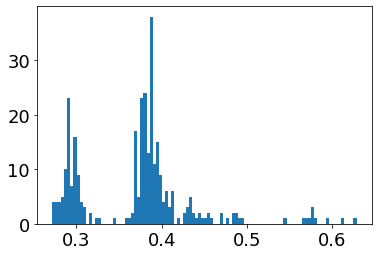

In [48]:
_=plt.hist(all_z_scores, bins=100)

In [39]:
def get_z_scores_logvar(logvar_df):
    mean = logvar_df.loc['thresh_mean_train'][0]
    std = logvar_df.loc['thresh_std_train'][0]
    pert_inds = [ind for ind in logvar_df.index 
                 if ind not in ['thresh_mean_train', 'thresh_std_train']]

    z_score_df = logvar_df.loc[pert_inds,:].apply(lambda x: (x-mean)/std)
    z_score_df = z_score_df.rename(columns={'0':'z-score'})
    return z_score_df

In [ ]:
logvar_df_file = '../GI_gene_mse/dfs/' + gene + '_crossgene_unc_logvar'
logvar_df = pd.read_csv(logvar_df_file)
logvar_df = logvar_df.set_index('condition')
thresh  = logvar_df.loc['thresh_mean_train'][0] + 0.386*logvar_df.loc['thresh_std_train'][0] 
return logvar_df[logvar_df['0']<thresh].index.values